# TorchVision Tutorial Based Pipeline

Following TORCHVISION OBJECT DETECTION FINETUNING TUTORIAL at https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pathlib import Path
import os
repo_path = Path.cwd()/'drive/MyDrive/calcification-detection-project/calcification_detecion/calc-det'
os.chdir(str(repo_path))

Copy extracted patches used for detection (224 size with stride 100) to the local machine. ***Needs to be done once per machine instantization***. 

~ 3 minutes to complete

In [3]:
# !cp -r /content/drive/MyDrive/calcification-detection-project/calcification_detecion/new_data_rois/data_rois.zip /home/
# !unzip /home/data_rois.zip -d /home
# !mv /home/home/vzalevskyi/projects/data_rois /home/data_rois
# !rm -r /home/home

In [4]:
thispath = Path.cwd().resolve()
import sys; sys.path.insert(0, str(thispath.parent))

In [5]:
# for colab it needs to be specified additionally
datapath = Path('/content/drive/MyDrive/calcification-detection-project/calcification_detecion/calc-det/data/INbreast Release 1.0')

dataset_arguments = {
    'extract_patches': False,
    'delete_previous': False,
    'extract_patches_method': 'all',
    'patch_size': 224,
    'stride': 100,
    'min_breast_fraction_roi': 0.7,
    'n_jobs': -1,
    'cropped_imgs': True,
    'ignore_diameter_px': 15,
    'neg_to_pos_ratio': None,
    'balancing_seed': 0,
    'normalization': 'min_max',
    'get_lesion_bboxes': True,
    'for_detection_net': True,
    'patch_images_path': Path('/home/data_rois/'), # FOR GDRIVE '/home/data_rois/', FOR LOCAL USE OWN PATH TO  the set of Detection patches

    # ONLY FOR COLAB NEED TO ADJUST PATH TO INBREAST due to the local import problem 
    'imgpath':datapath/'AllMasks',
    'mask_path': datapath/'AllMasks',
    'dfpath':datapath
}


If you see an error `AttributeError: 'NoneType' object has no attribute 'min'`, check that you have copied the patches to the local machine and/or you are using a proper path to the patches above in the `patch_images_path`

In [6]:
from deep_learning.dataset.dataset import INBreast_Dataset_pytorch


dataset_train = INBreast_Dataset_pytorch(
        partitions=['train'],
        **dataset_arguments

)

dataset_val = INBreast_Dataset_pytorch(
        partitions=['validation'],

        **dataset_arguments
    )

dataset_val[0]

/content/drive/MyDrive/calcification-detection-project/calcification_detecion/calc-det/deep_learning/dataset/dataset.py:51: DtypeWarning: Columns (16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  return_lesions_mask=get_lesion_bboxes, max_lesion_diam_mm=None, use_muscle_mask=False


(tensor([[[0.8871, 0.8463, 0.8927,  ..., 0.8206, 0.8625, 0.8726],
          [0.8698, 0.8631, 0.8653,  ..., 0.8692, 0.8765, 0.8876],
          [0.8720, 0.8524, 0.8703,  ..., 0.8480, 0.8748, 0.8916],
          ...,
          [0.7177, 0.7289, 0.7339,  ..., 0.0000, 0.0000, 0.0000],
          [0.7507, 0.7373, 0.7289,  ..., 0.0000, 0.0000, 0.0000],
          [0.7524, 0.7255, 0.7334,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.8871, 0.8463, 0.8927,  ..., 0.8206, 0.8625, 0.8726],
          [0.8698, 0.8631, 0.8653,  ..., 0.8692, 0.8765, 0.8876],
          [0.8720, 0.8524, 0.8703,  ..., 0.8480, 0.8748, 0.8916],
          ...,
          [0.7177, 0.7289, 0.7339,  ..., 0.0000, 0.0000, 0.0000],
          [0.7507, 0.7373, 0.7289,  ..., 0.0000, 0.0000, 0.0000],
          [0.7524, 0.7255, 0.7334,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.8871, 0.8463, 0.8927,  ..., 0.8206, 0.8625, 0.8726],
          [0.8698, 0.8631, 0.8653,  ..., 0.8692, 0.8765, 0.8876],
          [0.8720, 0.8524, 0.8703,  ...,

We need some helper modules for torch vision. I added the files to the `'notebooks/colab/vision_utils')` folder, but initially I got them as advised in the tutorial from

In [7]:
# # Download TorchVision repo to use some files from
# # references/detection

# !git clone https://github.com/pytorch/vision.git
# !cd vision
# !git checkout v0.8.2
# !
# !cp references/detection/utils.py ../
# !cp references/detection/transforms.py ../
# !cp references/detection/coco_eval.py ../
# !cp references/detection/engine.py ../
# !cp references/detection/coco_utils.py ../

In [8]:
sys.path.insert(0, str(thispath / 'notebooks/colab/vision_utils'))

In [9]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

Modules above are the ones that actually do the training and need to be incorporated to the training pipeline

In [11]:
import torch
import torch.nn as nn
from torchvision import models
from collections import OrderedDict
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader

import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
import math

from deep_learning.models.base_classifier import  CNNClasssifier

import matplotlib.pyplot as plt
import numpy as np


In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(dataset_train, batch_size=4, shuffle=True, sampler=None, collate_fn=collate_fn,
           batch_sampler=None, num_workers=4, pin_memory=True, drop_last=False)

data_loader_test = DataLoader(dataset_val, batch_size=4, shuffle=True, sampler=None, collate_fn=collate_fn,
           batch_sampler=None, num_workers=4, pin_memory=True, drop_last=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Cheking images and patches and bboxes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[104., 201., 118., 215.]])
tensor([1])
tensor([[[0.8642, 0.8268, 0.8419,  ..., 0.6939, 0.6682, 0.6866],
         [0.8151, 0.7939, 0.8168,  ..., 0.6844, 0.6693, 0.6961],
         [0.8358, 0.8207, 0.8536,  ..., 0.6771, 0.6911, 0.6749],
         ...,
         [0.6933, 0.7000, 0.7145,  ..., 0.0000, 0.0000, 0.0000],
         [0.7123, 0.7006, 0.7257,  ..., 0.0000, 0.0000, 0.0000],
         [0.7050, 0.7173, 0.7089,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.8642, 0.8268, 0.8419,  ..., 0.6939, 0.6682, 0.6866],
         [0.8151, 0.7939, 0.8168,  ..., 0.6844, 0.6693, 0.6961],
         [0.8358, 0.8207, 0.8536,  ..., 0.6771, 0.6911, 0.6749],
         ...,
         [0.6933, 0.7000, 0.7145,  ..., 0.0000, 0.0000, 0.0000],
         [0.7123, 0.7006, 0.7257,  ..., 0.0000, 0.0000, 0.0000],
         [0.7050, 0.7173, 0.7089,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.8642, 0.8268, 0.8419,  ..., 0.6939, 0.6682, 0.6866],
         [0.8151, 0.7939, 0.8168,  ..., 0.6844, 0.6693, 0.6961],
         [0

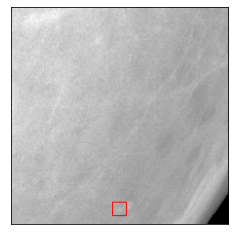

In [13]:
for image, target in data_loader:
    print(target[0]['boxes'])
    print(target[0]['labels'])
    print(image[0])
    break


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        
result = draw_bounding_boxes((255*image[0]).to(torch.uint8), target[0]['boxes'], colors=['red']*len(target[0]['boxes']),  width=1)
show(result)
print(target[0]['boxes'])

In [14]:
def get_detection_model(num_classes):

    # LOAD OUR BEST RESNET
    best_model_path = '/content/drive/MyDrive/calcification-detection-project/calcification_detecion/data/deepl_runs/resnet50_05/resnet50_05.pt'
    chkpt_path = '/content/drive/MyDrive/calcification-detection-project/calcification_detecion/data/deepl_runs/resnet50_05/resnet50_05_chkpt.pt'
    resnet50_model = CNNClasssifier(backbone='resnet50', fc_dims=None).model
    
    # load best model weights
    best_model = torch.load(best_model_path)
    resnet50_model.load_state_dict(best_model['model_state_dict'])

    modules = list(resnet50_model.children())[:-2]      # delete the last fc layers.
    resnet50_model_backbone = nn.Sequential(*modules)

    

    backbone = resnet50_model_backbone
    backbone.out_channels = 2048 # number of bottleneck features (passed to first FC layer)

    # defining our own set of acnhors
    anchor_generator = AnchorGenerator(sizes=((16, 32),),
                                    aspect_ratios=((1.0),))

    # not sure what these do, just leave them like this
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)

    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                    num_classes=num_classes,
                    rpn_anchor_generator=anchor_generator,
                    box_roi_pool=roi_pooler)

    return model

Now let's instantiate the model and the optimizer

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_detection_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [ ]:
# let's train it for 30 epochs
num_epochs = 30

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Save the model

In [ ]:
# torch.save(model.state_dict(), thispath/'test_model.pt')
